# Classifying MNIST by RNN

In [1]:
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

In [2]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

- 이 실습에서는 MNIST 손글씨 숫자 데이터셋을 시퀀스 데이터 셋으로 간주하고 RNN으로 분류하는 모델을 만들어봅니다.

- MNIST 샘플은 28x28 사이즈인 이미지 데이터 인데 각 행을 한 타임 스탭으로 간주하면 총 28개 타임스탭으로 구성된 데이터로 볼 수 있습니다.

- 총 28개 행을 RNN Cell에 순차적으로 입력하고 마지막 28번째 행이 입력된 다음 출력되는 출력 벡터를 `Linear`레이어에 입력하여 10개 클래스로 구분할 수 있습니다.

## Hyper-Param.

In [3]:
# epoch
epochs = 10

# batch_size
m = 64

# learning_rate
lr = 0.0001


## 데이터 셋 로드

In [4]:
trfms = T.Compose([ T.ToTensor(), ])

In [5]:
download = not os.path.exists("./data")

D_train = torchvision.datasets.MNIST(
    root='./data', # 데이터 저장 위치
    train=True, # True: train set, False: test set
    transform=trfms,
    download=download # 다운로드 여부, (이미 다운받았으면 False로 지정)
)

D_test = torchvision.datasets.MNIST(
    root='./data', # 데이터 저장 위치
    train=False, # True: train set, False: test set
    transform=trfms,
    download=download # 다운로드 여부, (이미 다운받았으면 False로 지정)
)

100%|██████████| 9912422/9912422 [00:00<00:00, 90045094.86it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111337953.88it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25189365.36it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18676988.99it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
print("# of Train Set:", len(D_train))
print("# of Test Set:", len(D_test))

# of Train Set: 60000
# of Test Set: 10000


## 데이터 로더

In [7]:
train_loader = torch.utils.data.DataLoader(D_train, batch_size=m, shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(D_test, batch_size=m, shuffle=True,
                                           num_workers=2)

## 데이터 확인

In [8]:
train_loader_iter = iter(train_loader)
X_batched, y_batched = next(train_loader_iter)

In [9]:
print(X_batched.shape)
print(y_batched.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


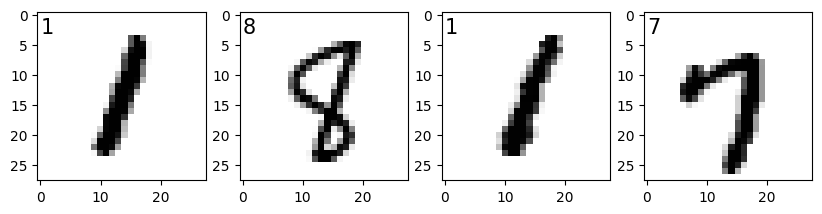

In [10]:
# 4개만 가져와서 그림 그리기
X = X_batched[:4].squeeze() # (N, 1, 28, 28) -> (N, 28, 28)
y = y_batched[:4]

fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=4)

for i in range(4):
    ax[i].imshow(X[i], cmap='binary')
    ax[i].text(0, 3, y[i].item(), color='k', fontsize=15)
plt.show()

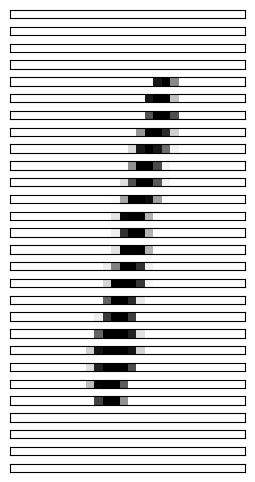

In [11]:
fig, ax = plt.subplots(figsize=(10,6), nrows=28, ncols=1)
fig.subplots_adjust(hspace=1, wspace=0)
for i in range(28):
    ax[i].xaxis.set_major_locator(plt.NullLocator()) # 눈금 숫자 모두 지움
    ax[i].yaxis.set_major_locator(plt.NullLocator()) # 눈금 숫자 모두 지움
    ax[i].imshow(X[2][i:i+1], cmap='binary')

plt.show()

- 위 그림은 이미지 샘플 하나를 28개 스탭으로 구성된 시퀀스 데이터로 간주하는 것에 대한 이해를 돕기 위해 출력되었습니다.

## Define Model

- 여기서는 간단하게 `Sequential`로 모델을 구성합니다.

- Sequential(RNN, Linear) 순으로 배치할 때 한가지 유의해야할 점이 있습니다.

- RNN의 출력은 `output`: `(N, L, Hout)`, `hn`: `(1, N, Hout)`로 나오기 때문에 이를 바로 `Linear`층에 입력할 수 없습니다.

- `Linear`는 `Hout`을 길이 10짜리 출력벡터로 변환하는 역할을 해야 하기 때문에 RNN의 출력을 `(N,Hout)`으로 정리할 필요가 있습니다.

- 이를 위해 사용저의 정의 `Module`을 정의해서 `RNN`과 `Linear`사이에 배치하고 사용자 정의 `Module` `forward`함수에서 `RNN`의 출력을 정리해야 합니다.

- 아래 뼈대 코드가 제시되어 있습니다. 주석을 잘 읽고 빈칸을 완성하세요.

In [ ]:
class ExtractLastCell(torch.nn.Module):
    def forward(self, x):
        # x는  RNN에서 되돌린
        # output:(N, L, Hout) (batch first인 경우)과
        # hn: (1, N, Hout)이 들어있는 튜플

        # x로 부터 output, hn 분리
        out, hn = x

        # RNN이 L 타임스탭동안 출력한 모든 출력에서 마지막 결과만 추출하여 되돌림
        # out: (N, L, Hout) : (64, 28, 256)64개의 샘플 28개의 타임스텝, 256의 벡터출력
        # hn:  (1, N, Hout) : (1, 64, 256)
        return hn[0] # or out[:, -1, :] 즉 (64,256)

###################################################
# WRITE YOUR CODE HERE
# torch.nn.RNN()과 torch.nn.Linear를 사용하여 MNIST를 분류하는 모델 완성하기
# torch.nn.RNN의 입출력 세부사항
#
# 입력
#   input: tensor of shape (N, L, Hin), 현재 경우: (N, 28, 28)
#   h0: tensor of shape (D*num_layer, N, Hout), 현재 경우: (1, N, 256)
# 출력
#   output: tensor of shape (N, L, D*Hout), 현재 경우: (N, 28, 256)
#   hn: tensor of shape (D*num_layer, N, Hout), 현재 경우: (1, N, 256)

model = torch.nn.Sequential(
        # 여기 순차적으로 레이어를 배치하세요.
        # 1. rnn, hidden_size=256, batch_first=True
        torch.nn.RNN(input_size=28, hidden_size=256, batch_first=True), # for loop 28번 돌아감
        # 출력 output:(64, 28, 256), hn: (1, 64, 256)

        # 2. extraclastcell()을 적절한 순서에 위치시키세요.
        ExtractLastCell(),
        # 출력: (64, 256)

        # 3. torch.nn.Linear()
        torch.nn.Linear(256, 10), # 0~9까지 분류 이므로 9

        # 4. 이 모델의 마지막 활성함수를 지정합니다.
        # 아래쪽셀에 ciriterion가 torch.nn.NLLLoss()로 지정되었으므로
        # 이에 맞게 마지막은 활성함수작성하세요.
        torch.nn.LogSoftmax(dim=-1)
    )


###################################################

In [ ]:
# 포워드 테스트
# 샘플 2개를 입력하고 포워드 테스트를 합니다.
# 위 셀에서 만든 모델이 어떤 모양의 텐서를 입력으로 받는지
# 잘 생각한 후 무작위로 초기화된 임의 텐서 크기를 지정하고 포워드 합니다.
out = model(torch.rand(2,28,28))

# 출력은 (2,10)이 나오면 모델이 제대로 동작하는 것입니다.
out.shape

torch.Size([2, 10])

## Loss func. and Optimizer

In [ ]:
# 로스 함수와 옵티마이저를 바르게 초기화 하세요.
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Train

In [ ]:
model.to(device)

start = time.time()  # 시작 시간 저장

# 지정된 에폭 수만큼 외부루프를 순회합니다.
for e in range(epochs):

    # 모델을 학습시키기 위해 모델을 train모드로 바꿉니다.
    model.train()

    # DataLoader에 대해서 내부 루프를 돌면서
    # pytorch 기초에서 배운 학습의 5스탭을 반복합니다.
    for i, d in enumerate(train_loader):
        # DataLoader로 부터 받은 한 미니배치 안에는 입력 이미지  X와
        # 타겟 y가 매니배치 수 만큼 들어 있습니다.
        # X:(N, 1, 28, 28)이 되는데 채널 1은 필요없으므로 스퀴즈해서 없애줍니다.
        X = d[0].squeeze().to(device)
        y = d[1].to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    # 모든 샘플에 대한 학습을 마치고 1에폭이 완료되었으므로
    # 모델을 eval모드로 바꾸고 모델을 평가 합니다.
    model.eval()

    # 그래디언트 추적을 끄고
    with torch.no_grad():
        corr = 0
        loss_sum = 0.0

        # 학습 로더에 대해서 모두 순회하면서 테스트셋에 대한 성능 측정
        for j, d in enumerate(train_loader):
            X = d[0].squeeze().to(device)
            y = d[1].to(device)

            # 모델의 출력은 샘플당 10개 숫자가 포함된 log softmax가 적용된
            # (N,10) 텐서
            out = model(X)
            loss = criterion(out, y)

            # 전체 로스를 구하기 위해 샘플에 대해서 합산
            loss_sum += loss

            # 출력 out에 exp취해서 log를 지우고 argmax로 실제 예측 레이블을 구함
            y_pred = torch.argmax(torch.exp(out), dim=-1)

            # 타겟 y와 비교를 통해 맞춘 개수를 계산
            corr += ((y == y_pred).cpu().numpy().astype(int)).sum()
        train_acc = corr / len(D_train)
        train_loss = loss_sum / (j+1)

        corr = 0
        loss_sum = 0.0

        # 테스트 로더에 대해서 모두 순회하면서 테스트셋에 대한 성능 측정
        # 코드는 위쪽 루프와 완전히 동일
        for j, d in enumerate(test_loader):
            X = d[0].squeeze().to(device)
            y = d[1].to(device)
            out = model(X) # (N, 10) # log softmax
            loss = criterion(out, y)
            loss_sum += loss
            y_pred = torch.argmax(torch.exp(out), dim=-1)
            corr += ((y == y_pred).cpu().numpy().astype(int)).sum()
        test_acc = corr / len(D_test)
        test_loss = loss_sum / (j+1)

    print(f"EPOCH:{e+1:3d}, Train Loss:{train_loss:.6f}, Train Acc.:{train_acc:.6f}, Test Loss:{test_loss:.6f}, Test Acc.:{test_acc:.6f}")

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

EPOCH:  1, Train Loss:0.877552, Train Acc.:0.693183, Test Loss:0.863211, Test Acc.:0.709700
EPOCH:  2, Train Loss:0.586977, Train Acc.:0.812633, Test Loss:0.562508, Test Acc.:0.826000
EPOCH:  3, Train Loss:0.436827, Train Acc.:0.866983, Test Loss:0.419978, Test Acc.:0.875400
EPOCH:  4, Train Loss:0.341925, Train Acc.:0.897167, Test Loss:0.330245, Test Acc.:0.903000
EPOCH:  5, Train Loss:0.302349, Train Acc.:0.911167, Test Loss:0.296723, Test Acc.:0.915700
EPOCH:  6, Train Loss:0.261961, Train Acc.:0.924000, Test Loss:0.258234, Test Acc.:0.926500
EPOCH:  7, Train Loss:0.234688, Train Acc.:0.931767, Test Loss:0.235253, Test Acc.:0.934700
EPOCH:  8, Train Loss:0.217789, Train Acc.:0.935717, Test Loss:0.217284, Test Acc.:0.939600
EPOCH:  9, Train Loss:0.195063, Train Acc.:0.943017, Test Loss:0.200855, Test Acc.:0.943400
EPOCH: 10, Train Loss:0.222910, Train Acc.:0.931800, Test Loss:0.223690, Test Acc.:0.929200
time : 181.67793250083923
